<a href="https://colab.research.google.com/github/Quantium/notebooks/blob/master/Loss_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# @title Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor, QuantileRegressor, RANSACRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
#@title Dark Mode
plt.style.use('seaborn-v0_8-whitegrid')

plt.style.use('dark_background')
plt.rcParams.update({
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'grid.color': 'lightgray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'font.size': 10,
    'figure.figsize': (8, 6),
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'legend.edgecolor': 'white',
    'legend.frameon': True,
    'legend.fancybox': False,
})

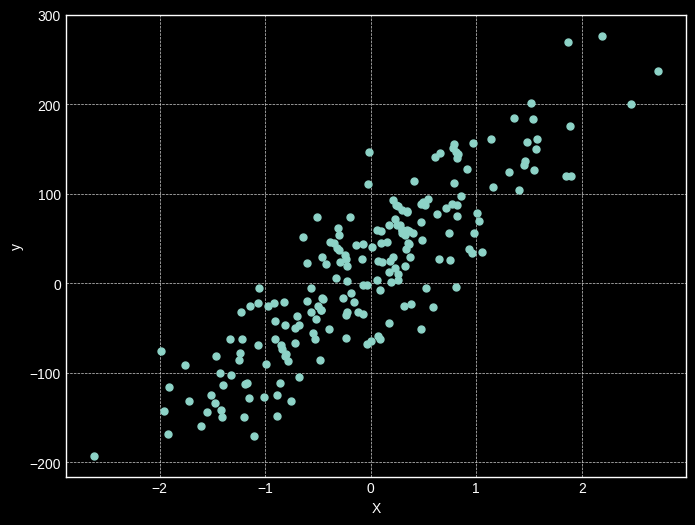

In [4]:
# @title Generar dataset con make_regression + outliers

import numpy as np
import pandas as pd

from sklearn.datasets import make_regression

np.random.seed(42)

X, y, true_coef = make_regression(
    n_samples=200,
    n_features=1,
    noise=42,
    coef=True,
    bias=10.0
)

# Inyectar outliers
outlier_idx = np.random.choice(len(y), size=10, replace=False)
y[outlier_idx] += np.random.normal(50, 10, size=10)

X = X.reshape(-1, 1)

plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

# Entrenar modelos con distintas funciones de pérdida

In [10]:
# @title MSE (OLS)
model_mse = LinearRegression()
model_mse.fit(X, y)
y_pred_mse = model_mse.predict(X)


In [6]:
# @title MAE real (mediana condicional)
model_mae = QuantileRegressor(
    quantile=0.5,
    alpha=0.0,
    solver="highs"
)
model_mae.fit(X, y)
y_pred_mae = model_mae.predict(X)

In [7]:
model_huber = HuberRegressor(epsilon=1.35)
model_huber.fit(X, y)
y_pred_huber = model_huber.predict(X)

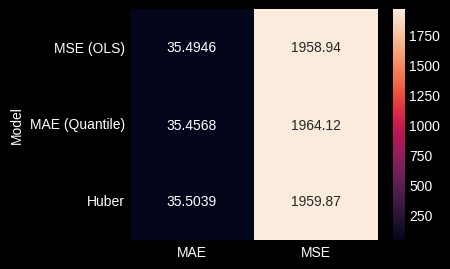

In [8]:
# @title Comparar Métricas
results = pd.DataFrame({
    "Model": ["MSE (OLS)", "MAE (Quantile)", "Huber"],
    "MAE": [
        mean_absolute_error(y, y_pred_mse),
        mean_absolute_error(y, y_pred_mae),
        mean_absolute_error(y, y_pred_huber)
    ],
    "MSE": [
        mean_squared_error(y, y_pred_mse),
        mean_squared_error(y, y_pred_mae),
        mean_squared_error(y, y_pred_huber)
    ]
})
results.set_index("Model", inplace=True)

fig, ax = plt.subplots(figsize=(4, 3))
_ = sns.heatmap(results, annot=True, fmt='g',  ax=ax)

In [9]:
# @title Comparar coeficientes aprendidos
coef_df = pd.DataFrame({
    "Model": ["True", "MSE (OLS)", "MAE (Quantile)", "Huber"],
    "Intercept": [
        np.nan,
        model_mse.intercept_,
        model_mae.intercept_,
        model_huber.intercept_
    ],
    "Slope": [
        true_coef,
        model_mse.coef_[0],
        model_mae.coef_[0],
        model_huber.coef_[0]
    ]
})

coef_df

coef_df = coef_df.iloc[1:]
print(coef_df)

# coef_df.set_index("Model", inplace=True)

# fig, ax = plt.subplots(figsize=(4, 3))
# _ = sns.heatmap(coef_df, annot=True, fmt='g',  ax=ax)


            Model  Intercept      Slope
1       MSE (OLS)  18.270004  86.412495
2  MAE (Quantile)  18.439916  83.977819
3           Huber  19.221832  86.632691


# Comparación de Regresiones

- **LinearRegression (OLS)**. es el baseline y el más interpretable cuando aplica
  - Usa todos los puntos. Sensible a outliers. Mejor si los datos son “limpios”
  - Minimiza MSE → estima media condicional. Outliers mandan.

- **RANSACRegressor**. No determinista y más caro computacionalmente
  - Descarta outliers explícitamente. Muy robusto. Ideal si hay datos corruptos
  - Estima la media sólo con inliers. Outliers = basura.

- **HuberRegressor**. Necesita elegir epsilon
  - Compromiso elegante. Outliers pesan menos, pero siguen contando.
  - Minimiza una pérdida híbrida → estima algo cercano a la media, pero robusta.

- QuantileRegressor.Es robusto por construcción y sirve para modelar asimetrías y riesgos. Aquí va la comparación integrada.
  - Minimiza pinball loss → estima un cuantil condicional.
    - q=0.5 ≈ mediana
    - q=0.9 ≈ escenario pesimista
    - q=0.1 ≈ escenario optimista

In [20]:
# datos base
X, y = make_regression(
    n_samples=100,
    n_features=1,
    noise=10,
    random_state=42
)

X_plot = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)

# agregamos outliers
rng = np.random.RandomState(0)
y[::10] += 50 * rng.randn(10)

## Regresión lineal “normal” (OLS)

Esto es mínimos cuadrados ordinarios: penaliza fuerte los outliers.

In [21]:
# @title El modelo *persigue* a los outliers porque el error se eleva al cuadrado.
model_ols = LinearRegression()
model_ols.fit(X, y)

print("OLS coef:", model_ols.coef_[0])
print("OLS intercept:", model_ols.intercept_)


OLS coef: 47.44626537906148
OLS intercept: 5.167715250597636


## Regresión robusta (RANSAC)

RANSAC ignora puntos que no encajan bien en un subconjunto consistente.

```
# This is formatted as code
```



In [22]:
# @title Identifica inliers vs outliers y ajusta sólo con los buenos. Ideal cuando los outliers son claramente errores o anomalías.
model_ransac = RANSACRegressor(
    estimator=LinearRegression(),
    min_samples=0.5,
    random_state=42
)

model_ransac.fit(X, y)

print("RANSAC coef:", model_ransac.estimator_.coef_[0])
print("RANSAC intercept:", model_ransac.estimator_.intercept_)


RANSAC coef: 44.26834924817835
RANSAC intercept: 1.1227896610152959


## Regresión de Huber (robusta y suave)

Huber combina MSE y MAE: cuadrático cerca de 0, lineal para errores grandes.

In [23]:
# @title No descarta puntos como RANSAC, pero **reduce su influencia**
model_huber = HuberRegressor(
    epsilon=1.35,   # umbral entre MSE y MAE
    alpha=0.0       # sin regularización para comparar limpio
)

model_huber.fit(X, y)

print("Huber coef:", model_huber.coef_[0])
print("Huber intercept:", model_huber.intercept_)


Huber coef: 45.06330932689466
Huber intercept: 1.7554644634603016


## Quantile Regression

Estima un cuantil (mediana, p90, p10). Es robusto por construcción y sirve para modelar asimetrías y riesgos

In [24]:
# @title Definimos 3, uno para cada quantile (.5,.9,.1)
# mediana (quantile = 0.5)
qr_med = QuantileRegressor(quantile=0.5,alpha=0.0,solver="highs")
qr_p90 = QuantileRegressor(quantile=0.9, alpha=0.0, solver="highs")
qr_p10 = QuantileRegressor(quantile=0.1, alpha=0.0, solver="highs")

qr_med.fit(X, y)
qr_p90.fit(X, y)
qr_p10.fit(X, y)

print("Quantile (0.5) coef:", qr_med.coef_[0])
print("Quantile 0.9 coef:", qr_p90.coef_[0])
print("Quantile 0.1 coef:", qr_p10.coef_[0])


Quantile (0.5) coef: 45.30473700277454
Quantile 0.9 coef: 48.636297084360805
Quantile 0.1 coef: 42.42931087722763


In [74]:
y_ols = model_ols.predict(X_plot)
y_huber = model_huber.predict(X_plot)
y_ransac = model_ransac.predict(X_plot)
y_quantile = qr_med.predict(X_plot)
y_quantile90 = qr_p90.predict(X_plot)
y_quantile10 = qr_p10.predict(X_plot)

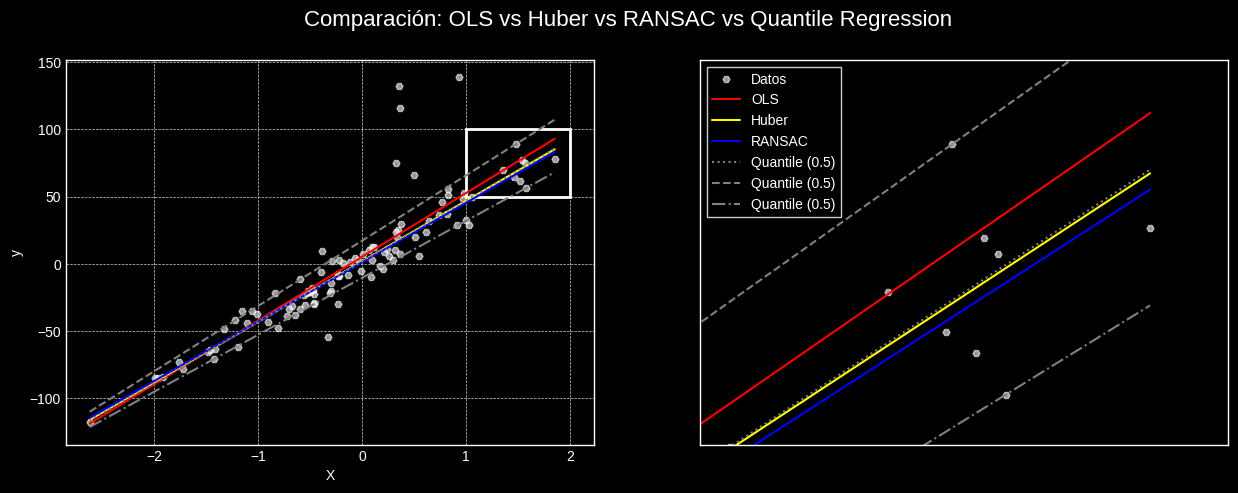

In [132]:
# @title Graficamos

import matplotlib.patches as patches

# Figura
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# datos

# for axe duplication
def plot_axe(ax,title):
  ax.scatter(X, y, alpha=0.6, label="Datos",marker="H",color="white")
  ax.plot(X_plot, y_ols, label="OLS",linestyle="-",color="red")
  ax.plot(X_plot, y_huber, label="Huber",linestyle="-",color="yellow")
  ax.plot(X_plot, y_ransac, label="RANSAC",linestyle="-",color="blue")
  ax.plot(X_plot, y_quantile, label="Quantile (0.5)",linestyle=":",color="gray")
  ax.plot(X_plot, y_quantile90, label="Quantile (0.5)",linestyle="--",color="gray")
  ax.plot(X_plot, y_quantile10, label="Quantile (0.5)",linestyle="-.",color="gray")

plot_axe(axes[0],"All values")
plot_axe(axes[1],"Zoom-in")

sq=[1,50,2,100]
square = patches.Rectangle((sq[0], sq[1]), width=sq[2]-sq[0], height=sq[3]-sq[1], edgecolor='white', facecolor='None', linewidth=2)
axes[0].add_patch(square)
axes[1].legend()
axes[0].set_xlabel("X")
axes[0].set_ylabel("y")
axes[1].set_xlim(sq[0], sq[2])
axes[1].set_ylim(sq[1], sq[3])
axes[1].grid(False)
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])

fig.suptitle('Comparación: OLS vs Huber vs RANSAC vs Quantile Regression', fontsize=16)

plt.show()